In [6]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

In [7]:
# -*- coding: utf-8 -*-
'''Sample script for solar array image classification

Author:       Kyle Bradbury
Date:         January 30, 2018
Organization: Duke University Energy Initiative
'''

'''
Import the packages needed for classification
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
plt.close()


'\nSet directory parameters\n'

In [31]:
dir_train_images  = './data/training/'
dir_test_images   = './data/testing/'
dir_train_labels  = './data/labels_training.csv'
dir_test_ids      = './data/sample_submission.csv'


In [9]:
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

def preprocess_and_extract_features(data):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    # Here, we do something trivially simple: we take the average of the RGB
    # values to produce a grey image, transform that into a vector, then
    # extract the mean and standard deviation as features.
    
    # Make the image grayscale
    data = np.mean(data, axis=3)
    
    # Vectorize the grayscale matrices
    vectorized_data = data.reshape(data.shape[0],-1)
    
    # extract the mean and standard deviation of each sample as features
    feature_mean = np.mean(vectorized_data,axis=1)
    feature_std  = np.std(vectorized_data,axis=1)
    
    # Combine the extracted features into a single feature vector
    features = np.stack((feature_mean,feature_std),axis=-1)
    
    return features

def set_classifier():
    '''Shared function to select the classifier for both performance evaluation
    and testing
    '''
    return KNeighborsClassifier(n_neighbors=7)

def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = preprocess_and_extract_features(X_val)
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()

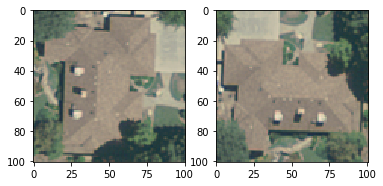

In [60]:
f,ax = plot.subplots(1,2)
ax[0].imshow(np.rot90(data[1],1))
ax[1].imshow(np.rot90(data[1],2))

In [130]:
np.random.randint(0,4)

0

In [62]:
data.shape[0]

(1500, 101, 101, 3)

In [139]:
data2 = []
for i in range(data.shape[0]):
    data2.append(np.rot90(data[i],np.random.randint(0,4)))
data2 = np.array(data2)

In [143]:
data3 = []
for j in range(4):
    for i in range(data.shape[0]):
        data3.append(np.rot90(data[i],j))
data3 = np.array(data3)

In [146]:
labels3 = np.concatenate((labels,labels,labels,labels),axis = 0)

In [148]:
labels.shape

(1500,)

In [142]:
data3.shape

(6000, 101, 101, 3)

In [ ]:
# Rotate it by 45 degrees

rotated     = colorImage.rotate(45)

# Rotate it by 90 degrees

transposed  = colorImage.transpose(Image.ROTATE_90)

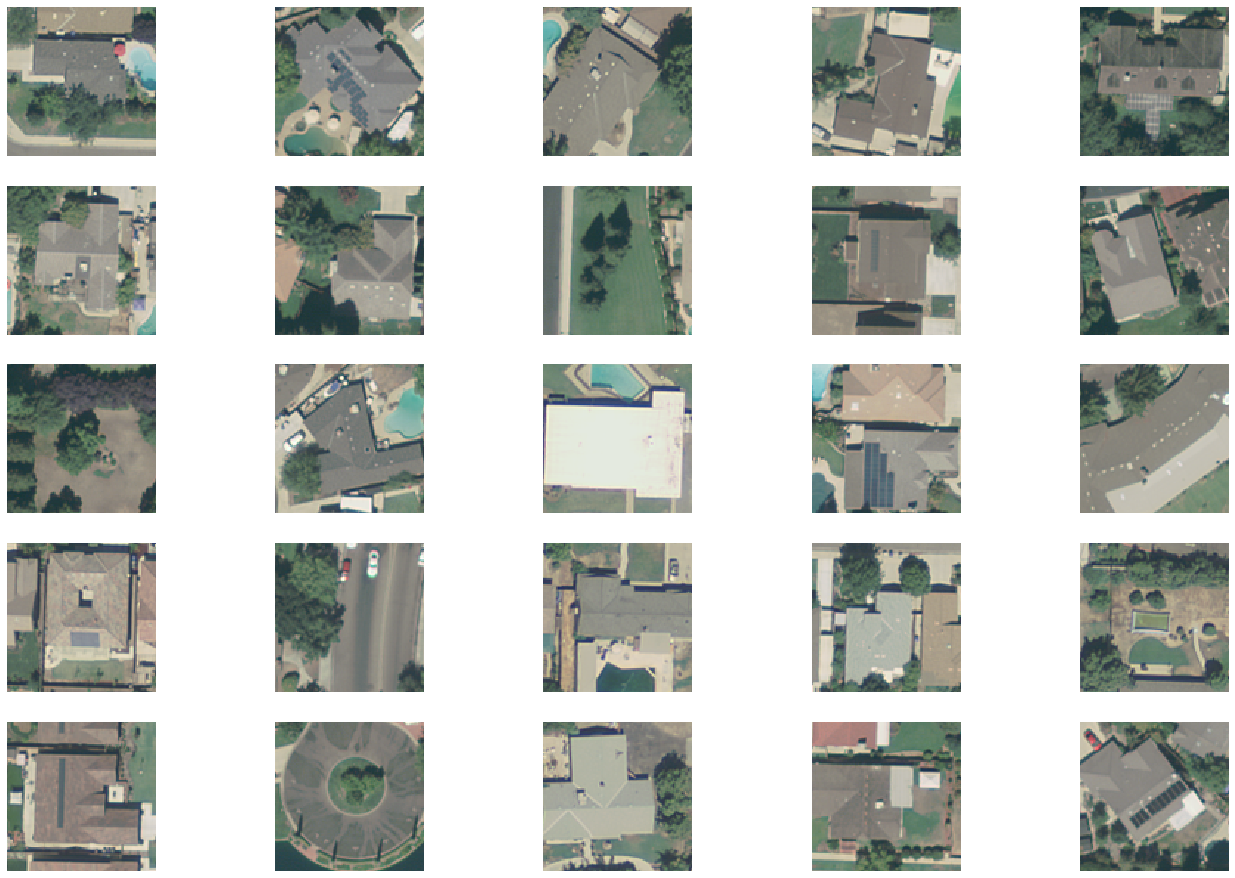

In [12]:
data, labels = load_data(dir_train_images, dir_train_labels, training=True)

f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(data))
        ax[i,j].imshow(data[rnd_number])
        ax[i,j].axis('off')

In [190]:
#Trial model
model = Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(101,101,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
#Utils.plot_model(model,to_file='model.png',show_shapes=True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 99, 99, 200)       5600      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 97, 97, 180)       324180    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 19, 19, 180)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 17, 17, 180)       291780    
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 15, 15, 140)       226940    
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 13, 13, 100)       126100    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 11, 11, 50)      

In [41]:
trained = model.fit(data,labels,epochs=5,validation_split=0.10)

Train on 1350 samples, validate on 150 samples
Epoch 1/5
1350/1350 [==============================] - 241s 178ms/sample - loss: 0.0492 - acc: 0.9822 - val_loss: 0.3296 - val_acc: 0.9067
Epoch 2/5
1350/1350 [==============================] - 241s 178ms/sample - loss: 0.0466 - acc: 0.9859 - val_loss: 0.4316 - val_acc: 0.9067
Epoch 3/5
1350/1350 [==============================] - 251s 186ms/sample - loss: 0.0364 - acc: 0.9926 - val_loss: 0.3141 - val_acc: 0.9467
Epoch 4/5
1350/1350 [==============================] - 238s 176ms/sample - loss: 0.0173 - acc: 0.9948 - val_loss: 0.3441 - val_acc: 0.9200
Epoch 5/5
1350/1350 [==============================] - 249s 184ms/sample - loss: 0.0170 - acc: 0.9941 - val_loss: 0.6043 - val_acc: 0.9000


In [162]:
trained = model.fit(data3,labels3,epochs=7,validation_split=0.35)

Train on 3900 samples, validate on 2100 samples
Epoch 1/7
3900/3900 [==============================] - 798s 205ms/sample - loss: 0.1780 - acc: 0.9438 - val_loss: 0.3170 - val_acc: 0.9000
Epoch 2/7
3900/3900 [==============================] - 809s 207ms/sample - loss: 0.1385 - acc: 0.9556 - val_loss: 0.2482 - val_acc: 0.9181
Epoch 3/7
3900/3900 [==============================] - 799s 205ms/sample - loss: 0.1173 - acc: 0.9633 - val_loss: 0.4641 - val_acc: 0.8862
Epoch 4/7
3900/3900 [==============================] - 794s 204ms/sample - loss: 0.0919 - acc: 0.9710 - val_loss: 0.3161 - val_acc: 0.9129
Epoch 5/7
3900/3900 [==============================] - 798s 205ms/sample - loss: 0.0531 - acc: 0.9826 - val_loss: 0.2887 - val_acc: 0.9352
Epoch 6/7
3900/3900 [==============================] - 783s 201ms/sample - loss: 0.0699 - acc: 0.9774 - val_loss: 0.2734 - val_acc: 0.9214
Epoch 7/7
3900/3900 [==============================] - 775s 199ms/sample - loss: 0.0616 - acc: 0.9795 - val_loss: 0.32

In [208]:
cnn_classifier_rotated = Models.Sequential()


cnn_classifier_rotated.add(Layers.Conv2D(128, (3, 3), input_shape = (101, 101, 3), activation = 'relu'))
cnn_classifier_rotated.add(Layers.MaxPooling2D(pool_size = (2, 2)))
cnn_classifier_rotated.add(Layers.Dropout(.25))


cnn_classifier_rotated.add(Layers.Conv2D(128, (3, 3), activation = 'relu')) 
cnn_classifier_rotated.add(Layers.MaxPooling2D(pool_size = (2, 2)))
cnn_classifier_rotated.add(Layers.Dropout(.25))


cnn_classifier_rotated.add(Layers.Conv2D(64, (3, 3), activation = 'relu')) 
cnn_classifier_rotated.add(Layers.MaxPooling2D(pool_size = (2, 2)))
cnn_classifier.add(Layers.Dropout(.25))

cnn_classifier_rotated.add(Layers.Conv2D(32, (3, 3), activation = 'relu')) 
cnn_classifier_rotated.add(Layers.MaxPooling2D(pool_size = (2, 2)))
cnn_classifier_rotated.add(Layers.Dropout(.25))


cnn_classifier_rotated.add(Layers.Flatten())


cnn_classifier_rotated.add(Layers.Dense(units = 128, activation = 'relu'))
cnn_classifier_rotated.add(Layers.Dropout(0.3))
cnn_classifier_rotated.add(Layers.Dense(units = 1, activation = 'softmax'))

cnn_classifier_rotated.summary()

# Compiling the CNN
# Second attempt steps: 5000 and epochs: 5
# Validation steps = 2000
learning_rate = 1
decay_rate = learning_rate / 50
cnn_classifier_rotated.compile(optimizer = Optimizer.SGD(lr=learning_rate, decay=decay_rate, momentum=0.9, nesterov=True), 
                       loss = 'binary_crossentropy', 
                       metrics = ['accuracy'])

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 99, 99, 32)        896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 21, 21, 128)     

In [206]:
cnn_classifier = Models.Sequential()


cnn_classifier.add(Layers.Conv2D(32, (3, 3), input_shape = (101, 101, 3), activation = 'relu'))
cnn_classifier.add(Layers.MaxPooling2D(pool_size = (2, 2)))
cnn_classifier.add(Layers.Dropout(.25))


cnn_classifier.add(Layers.Conv2D(64, (3, 3), activation = 'relu')) 
cnn_classifier.add(Layers.MaxPooling2D(pool_size = (2, 2)))
cnn_classifier.add(Layers.Dropout(.25))


cnn_classifier.add(Layers.Conv2D(128, (3, 3), activation = 'relu')) 
cnn_classifier.add(Layers.MaxPooling2D(pool_size = (2, 2)))
cnn_classifier.add(Layers.Dropout(.4))

cnn_classifier.add(Layers.Conv2D(128, (3, 3), activation = 'relu')) 
cnn_classifier.add(Layers.MaxPooling2D(pool_size = (2, 2)))
cnn_classifier.add(Layers.Dropout(.25))

cnn_classifier.add(Layers.Flatten())


cnn_classifier.add(Layers.Dense(units = 128, activation = 'relu'))
cnn_classifier.add(Layers.Dropout(0.4))
cnn_classifier.add(Layers.Dense(units = 1, activation ="sigmoid"))

cnn_classifier.summary()

# Compiling the CNN
# Second attempt steps: 5000 and epochs: 5
# Validation steps = 2000
cnn_classifier.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['accuracy'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 99, 99, 32)        896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 21, 21, 128)     

In [182]:
es = Models.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = Models.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model

AttributeError: module 'tensorflow.python.keras.api._v1.keras.models' has no attribute 'EarlyStopping'

In [203]:
data3.shape

(6000, 101, 101, 3)

In [210]:
trained3_rotated_images = cnn_classifier.fit(data3,labels3,epochs=50,validation_split=0.35)

Train on 3900 samples, validate on 2100 samples
Epoch 1/50
3900/3900 [==============================] - 40s 10ms/sample - loss: 1.6447 - acc: 0.6905 - val_loss: 0.5625 - val_acc: 0.6619
Epoch 2/50
3900/3900 [==============================] - 40s 10ms/sample - loss: 1.6377 - acc: 0.6800 - val_loss: 0.5635 - val_acc: 0.6710
Epoch 3/50
3900/3900 [==============================] - 40s 10ms/sample - loss: 1.7354 - acc: 0.7103 - val_loss: 0.5734 - val_acc: 0.6562
Epoch 4/50
3900/3900 [==============================] - 40s 10ms/sample - loss: 1.7126 - acc: 0.7205 - val_loss: 0.5503 - val_acc: 0.6762
Epoch 5/50
3900/3900 [==============================] - 41s 11ms/sample - loss: 1.7019 - acc: 0.7277 - val_loss: 0.5720 - val_acc: 0.6571
Epoch 6/50
3900/3900 [==============================] - 40s 10ms/sample - loss: 1.7131 - acc: 0.7379 - val_loss: 0.5110 - val_acc: 0.7671
Epoch 7/50
3900/3900 [==============================] - 41s 10ms/sample - loss: 1.5912 - acc: 0.7603 - val_loss: 0.5479 - va

In [209]:
trained3_rotated_images = cnn_classifier_rotated.fit(data3,labels3,epochs=10,validation_split=0.35)

Train on 3900 samples, validate on 2100 samples
Epoch 1/10
3900/3900 [==============================] - 40s 10ms/sample - loss: nan - acc: 0.6656 - val_loss: nan - val_acc: 0.6562
Epoch 2/10
3900/3900 [==============================] - 40s 10ms/sample - loss: nan - acc: 0.6672 - val_loss: nan - val_acc: 0.6562
Epoch 3/10
3264/3900 [========================>.....] - ETA: 5s - loss: nan - acc: 0.6612

KeyboardInterrupt: 

In [191]:
trained2 = model.fit(data3,labels3,epochs=20,validation_split=0.35)

Train on 3900 samples, validate on 2100 samples
Epoch 1/20
3900/3900 [==============================] - 791s 203ms/sample - loss: 1.0360 - acc: 0.5964 - val_loss: 0.6552 - val_acc: 0.6562
Epoch 2/20
3900/3900 [==============================] - 784s 201ms/sample - loss: 0.6923 - acc: 0.6546 - val_loss: 0.6481 - val_acc: 0.6562
Epoch 3/20
3900/3900 [==============================] - 775s 199ms/sample - loss: 0.6666 - acc: 0.6649 - val_loss: 0.6474 - val_acc: 0.6562
Epoch 4/20
3900/3900 [==============================] - 767s 197ms/sample - loss: 0.6641 - acc: 0.6672 - val_loss: 0.6480 - val_acc: 0.6562
Epoch 5/20
3900/3900 [==============================] - 767s 197ms/sample - loss: 0.6548 - acc: 0.6664 - val_loss: 0.6473 - val_acc: 0.6562
Epoch 6/20
3900/3900 [==============================] - 766s 196ms/sample - loss: 0.6608 - acc: 0.6669 - val_loss: 0.6468 - val_acc: 0.6562
Epoch 7/20
3900/3900 [==============================] - 773s 198ms/sample - loss: 0.6628 - acc: 0.6672 - val_los

KeyboardInterrupt: 

In [23]:
test_features

array([[[[ 91, 117,  94],
         [ 90, 117,  94],
         [ 89, 115,  94],
         ...,
         [ 80, 111,  92],
         [ 83, 125,  97],
         [131, 133, 121]],

        [[ 94, 120,  98],
         [ 89, 119, 100],
         [ 90, 120,  93],
         ...,
         [ 82, 117,  91],
         [101, 124, 106],
         [142, 132, 124]],

        [[ 95, 122, 104],
         [ 93, 122, 102],
         [ 96, 123, 101],
         ...,
         [ 82, 118,  95],
         [113, 123, 110],
         [140, 131, 124]],

        ...,

        [[211, 197, 180],
         [182, 178, 158],
         [184, 158, 149],
         ...,
         [115, 109, 105],
         [114, 109, 109],
         [116, 111, 103]],

        [[208, 197, 179],
         [189, 184, 163],
         [193, 177, 159],
         ...,
         [114, 112,  99],
         [116, 110,  99],
         [122, 115, 105]],

        [[210, 200, 179],
         [206, 195, 175],
         [204, 193, 172],
         ...,
         [119, 111, 102],
        

In [156]:
cnn_classifier_rotated.predict_proba(test_features).shape

(558, 1)

In [185]:
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
test_features  = test_data
test_scores    = cnn_classifier_rotated.predict_proba(test_features)[:,0]

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids,
                               'score':  test_scores})
submission_file.to_csv('submission_cnn_rotated2.csv',
                       columns=['id','score'],
                       index=False)


In [160]:
submission_file

,id,score
0,1500,0.000513
1,1501,0.000148
2,1502,0.996603
3,1503,0.519790
4,1504,0.008405
...,...,...
553,2053,0.001869
554,2054,0.001359
555,2055,0.997929
556,2056,0.002768


In [154]:
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
test_features  = test_data
test_scores    = model.predict_proba(test_features)[:,1]

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids,
                               'score':  test_scores})
submission_file.to_csv('submission_cnn_rotated.csv',
                       columns=['id','score'],
                       index=False)


In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 


Saved model to disk


In [ ]:

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
data, labels = load_data(dir_train_images, dir_train_labels, training=True)
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
test_features  = test_data
test_scores    = loaded_model.predict_proba(test_features)[:,1]



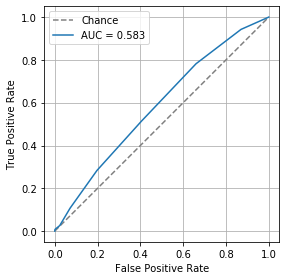

In [8]:

'''
Sample script for cross validated performance
'''
# Set parameters for the analysis
num_training_folds = 20

# Load the data
data, labels = load_data(dir_train_images, dir_train_labels, training=True)

# Choose which classifier to use
clf = set_classifier()

# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(data,labels,num_training_folds,clf)

# Compute and plot the ROC curves
plot_roc(labels, prediction_scores)


'''
Sample script for producing a Kaggle submission
'''

produce_submission = False # Switch this to True when you're ready to create a submission for Kaggle

if produce_submission:
    # Load data, extract features, and train the classifier on the training data
    training_data, training_labels = load_data(dir_train_images, dir_train_labels, training=True)
    training_features              = preprocess_and_extract_features(training_data)
    clf                            = set_classifier()
    clf.fit(training_features,training_labels)

    # Load the test data and test the classifier
    test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
    test_features  = preprocess_and_extract_features(test_data)
    test_scores    = clf.predict_proba(test_features)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
    submission_file.to_csv('submission.csv',
                           columns=['id','score'],
                           index=False)

